  

## <center>CSCI-UA 9473 Introduction to Machine Learning</center>
### <center>Spring 2022</center>
## <center>Assignment 3: Convolutional nets, SVM and Robust PCA</center>


<center><font color='red'><b>Given date: Wednesday April 5</b></font></center>

<center><font color='red'><b>Due date: Sunday April 24 </b></font></center>


#### <center>Total: 30pts</center>

Additional readings (To go further): 

 - [Ian Goodfellow and Yoshua Bengio and Aaron Courville, Deep Learning](https://www.deeplearningbook.org/)
 - [Saharon Rosset, Ji Zhu and Trevor Hastie, Margin Maximizing Loss Functions](https://web.stanford.edu/~hastie/Papers/margmax1.pdf)
 
The assignment is divided into three parts. In the first part, we will go back to neural networks. You will be asked to build and train a convolutional neural network for image classification. In the second part, we will focus on the max margin classifier and study how such a classifier can be learned by means of gradient descent. Finally, in the last part, we will implement a principal component decomposition of a video sequence to extract moving targets from their background. 

## Question I: (15pts) conv nets and autonomous driving 


In this first question, we will use [the Keras API](https://keras.io/) to build and train a convolutional neural network to discriminate between four types of road signs. To simplify we will consider the detection of 4 different signs: 

- A '30 km/h' sign (folder 1)
- A 'Stop' sign 
- A 'Go straight' sign
- A 'Keep left' sign 


<img src="learning2Drive.jpeg" style="width:400px">


An example of each sign is given below.

Mounted at /content/drive
/content/drive/My Drive/Assignment3


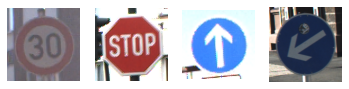

In [6]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/"Assignment3"/

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('1/00001_00000_00012.png')
plt.subplot(141)
plt.imshow(img1)
plt.axis('off')
plt.subplot(142)
img2 = mpimg.imread('2/00014_00001_00019.png')
plt.imshow(img2)
plt.axis('off')
plt.subplot(143)
img3 = mpimg.imread('3/00035_00008_00023.png')
plt.imshow(img3)
plt.axis('off')
plt.subplot(144)
img4 = mpimg.imread('4/00039_00000_00029.png')
plt.imshow(img4)
plt.axis('off')
plt.show()

### Question I.1. (10pts) 

In this exercise, you need to build and train a convolutional neural network to discriminate between the four images.  

- Before building the network, you should start by cropping the images so that they all have a common predefined size (take the smallest size across all images) 

- We will use a __Sequential model__ from Keras but it will be up to you to define the structure of the convolution net. Initialization of the sequential model can be done with the following line 

In [ ]:
from tensorflow.keras import Sequential
model = Sequential()

#### I.1.a. Convolutions. 

- We will use a __convolutional__ architecture. you can add convolutional layers to the model by using the following lines 

In [ ]:
from tensorflow.keras.layers import Conv2D
num_units = 32
filter_size1 = 5
filter_size2 = 5
IMG_SIZE = img1.shape[0]
model.add(Conv2D(num_units, (filter_size1, filter_size2), padding='same',
                             input_shape=(3, IMG_SIZE, IMG_SIZE),
                             activation='relu'))
                     

for the first layer and                     

In [ ]:
filters = 64
filter_size = (3, 3)
model.add(Conv2D(filters, filter_size, activation="relu", input_shape=(3, IMG_SIZE, IMG_SIZE)))

for all the others. 'filters' indicate the number of filters you want to use in the convolutional layer. filter_size is the size of each filter and activation is the usual activation that comes on top of the convolution, i.e.
$x_{\text{out}} = \sigma(\text{filter}*\text{input})$. Finally input_shape indicates the size of your input. Note that only the input layer should be given the input size. Subsequent layers will automatically compute the size of their inputs based on previous layers. 

#### I.1.b Pooling Layers 

On top of the convolutional layers, convolutional neural networks (CNN) also often rely on __Pooling layers__. The addition of such a  layer can be done through the following line 

In [ ]:
from tensorflow.keras.layers import MaxPooling2D
filter_sz1 = 1
filter_sz2 = 1
model.add(MaxPooling2D(pool_size=(filter_sz1, filter_sz2),strides=None))

  
The _pooling layers_ usually come with two parameters: the 'pool size' and the 'stride' parameter. The basic choice for the pool size is (2,2) and the stride is usually set to None (which means it will split the image into non overlapping regions such as in the Figure below). You should however feel free to play a little with those parameters. The __MaxPool operator__ considers a mask of size 'pool_size' which is slided over the image by a number of pixels equal to the stride parameters (in x and y, there are hence two translation parameters). for each position of the mask, the output only retains the max of the pixels appearing in the mask (This idea is illustrated below). One way to understand the effect of the pooling operator is that if the filter detects an edge in a subregion of the image (thus returning at least one large value), although a MaxPooling will reduce the number of parameters, it will keep track of this information.    

Adding 'Maxpooling' layers is known to work well in practice. 

<img src="Maxpool.png" style="width:500px">


Although it is a little bit up to you to decide how you want to structure the network, a good start is to add a couple (definitely not exceeding 4) combinations (convolution, convolution, Pooling) with increasing number of units (you do every power of two like 16, 32, 128,...). 

#### I.1.c. Flattening and Fully connected layers

Once you have stacked the convolutional and pooling layers, you should flatten the output through a line of the form

In [ ]:
from tensorflow.keras.layers import Flatten
model.add(Flatten())

And add a couple (no need to put more than 2,3) dense fully connected layers through lines of the form

In [ ]:
from tensorflow.keras.layers import Dense
model.add(Dense(num_units, activation='relu'))

#### I.1.d. Concluding 

Since there are four possible signs, you need to __finish your network with a dense layer with 4 units__. Each of those units should output four number between 0 and 1 representing the likelihood that any of the four signs is detected and such that $p_1 + p_2 + p_3 + p_4 = 1$ (hopefully with one probability much larger than the others). For this reason, a good choice for the __final activation function__ of those four units is the __softmax__ (Why?). 


Build your model below. 

In [ ]:
import os
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, ReLU, Dropout

def crop(path, w):
    X = []
    half = w // 2
    for each in os.listdir(path):
        img = mpimg.imread(path + "/" + each)
        width, height, color = img.shape
        mid_w = width // 2
        mid_h = height // 2
        X.append(img[(mid_w-half):(mid_w-half+w), (mid_h-half):(mid_h-half+w), :])
    return np.stack(X)

def width_height(path, min_w, min_h):
    for each in os.listdir(path):
        width, height, color = mpimg.imread(path + "/" + each).shape
        min_w = min(min_w, width)
        min_h = min(min_h, height)
    return min_w, min_h


w0 = float("inf")
h0 = float("inf")
c = []
t = []
l = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
X = []

for i in range(4):
    path = "./%d" % (i+1)
    c.append(os.listdir(path))
    min_w, min_h = width_height(path, w0, h0)
    t.append(np.stack([l[i].copy() for j in range(len(c[i]))]))
t = np.vstack(t)

for i in range(4):
    path = "./%d" % (i+1)
    X.append(crop(path, min_w))
X = np.vstack(X)

num_units = 4
IMG_SIZE = min(min_w, min_h)
model = Sequential()

model.add(Conv2D(32, (5, 5), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_units, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        2432      
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                589888    
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                      

### Question I.2 (3pts). Setting up the optimizer

Once you have found a good architecture for your network, split the dataset, by retaining about 90% of the images for training and 10% of each folder for test. To train your network in Keras, we need two more steps. The first step is to set up the optimizer. Here again it is a little bit up to you to decide how you want to set up the optimization. Two popular approaches are __SGD and ADAM__. You will get to choose the learning rate. This rate should however be between 1e-3 and 1e-2. Once you have set up the optimizer, we need to set up the optimization parameters. This includes the loss (we will take it to be the __categorical cross entropy__ which is the extension of the log loss to the multiclass problem).   

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# set up the optimize here
# Myoptimizer = SGD
# Myoptimizer = Adam
Myoptimizer = Adam(learning_rate=0.0002, decay=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=Myoptimizer,
              metrics=['accuracy'])

### Question I.3 (2pts). Optimization

The last step is to fit the network to your data. Just as any function in scikit-learn, we use a call to the function 'fit'. The training of neural networks can be done by splitting the dataset into minibatches and using a different batch at each SGD step. This process is repeated over the whole dataset. A complete screening of the dataset is called an epoch. We can then repeat this idea several times. In keras the number of epochs is stored in the 'epochs' parameter and the batch size is stored in the 'batch_size' parameter.   

In [ ]:
from sklearn.model_selection import train_test_split
batch_size = 32
epochs = 30
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.1, random_state=1)
model.fit(X_train, t_train, batch_size=batch_size, epochs=epochs, validation_split=0.15)
model.evaluate(X_test, t_test)

Epoch 1/30
108/108 [==============================] - 14s 14ms/step - loss: 0.5725 - accuracy: 0.8164 - val_loss: 0.2109 - val_accuracy: 0.9375
Epoch 2/30
108/108 [==============================] - 1s 10ms/step - loss: 0.1515 - accuracy: 0.9637 - val_loss: 0.1857 - val_accuracy: 0.9441
Epoch 3/30
108/108 [==============================] - 1s 10ms/step - loss: 0.0978 - accuracy: 0.9744 - val_loss: 0.0870 - val_accuracy: 0.9786
Epoch 4/30
108/108 [==============================] - 1s 11ms/step - loss: 0.0743 - accuracy: 0.9817 - val_loss: 0.0736 - val_accuracy: 0.9819
Epoch 5/30
108/108 [==============================] - 1s 11ms/step - loss: 0.0611 - accuracy: 0.9855 - val_loss: 0.0595 - val_accuracy: 0.9803
Epoch 6/30
108/108 [==============================] - 1s 10ms/step - loss: 0.0535 - accuracy: 0.9855 - val_loss: 0.0531 - val_accuracy: 0.9868
Epoch 7/30
108/108 [==============================] - 1s 10ms/step - loss: 0.0410 - accuracy: 0.9922 - val_loss: 0.0508 - val_accuracy: 0.986

[0.027238618582487106, 0.9933333396911621]

t_truth: Stop
t_pred: Stop


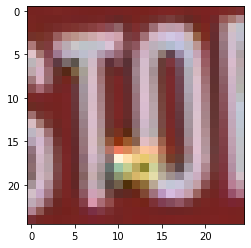


t_truth: 30 km/h
t_pred: 30 km/h


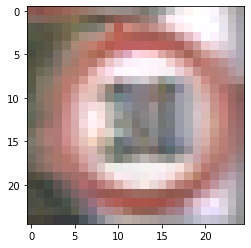


t_truth: 30 km/h
t_pred: 30 km/h


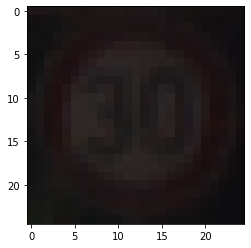


t_truth: 30 km/h
t_pred: 30 km/h


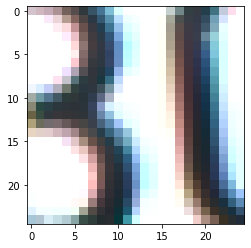


t_truth: 30 km/h
t_pred: 30 km/h


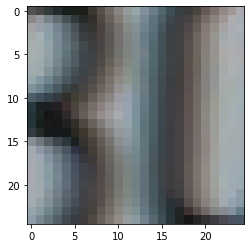


t_truth: Stop
t_pred: Stop


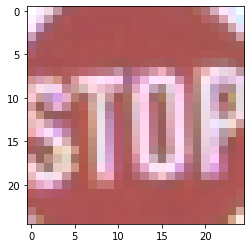


t_truth: Go straight
t_pred: Go straight


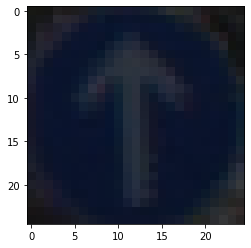


t_truth: 30 km/h
t_pred: 30 km/h


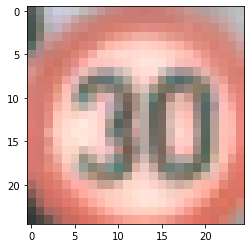


t_truth: Go straight
t_pred: Go straight


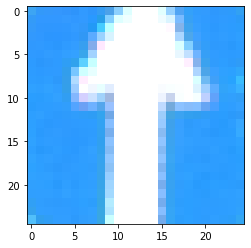


t_truth: 30 km/h
t_pred: 30 km/h


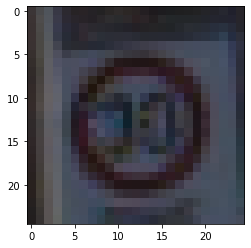

In [ ]:
label = {0: '30 km/h', 1: "Stop", 2: "Go straight", 3: "Keep left"}

for i in range(10):
  t_truth = label[np.argmax(t_test[i])]
  print("t_truth:", t_truth)
  t_pred = label[np.argmax(model.predict(np.expand_dims(X_test[i], axis=0)))]
  print("t_pred:", t_pred)
  plt.imshow(X_test[i])
  plt.show()
  print()


## Question II (10pts): Max margin classifiers and outliers

Consider the dataset below. We would like to learn a classifier for this dataset that maximizes the margin (i.e. such that the distance between the closest points to the classifier is maximized). We have seen that one can solve this problem by means of the constrained formulation

\begin{align*}
\min_{\mathbf{\beta}} \quad & \|\mathbf{\beta}\|^2 \\
\text{subject to} \quad & y(\mathbf{x}^{(i)})t^{(i)} \geq 1 
\end{align*}

where $y(\mathbf{x}^{(i)}) = \mathbf{\beta}^T\mathbf{x}^{(i)} + \beta_0$. We might sometimes want to use a (softer) unconstrained formulation. in particular, when selecting this option, we can use the following function known as the _Hinge loss_ 

\begin{align*}
\max(0, 1-t^{(i)}y(\mathbf{x}^{(i)})) = \max(0, 1-t^{(i)}(\mathbf{\beta}^T\mathbf{x}^{(i)}+\beta_0))
\end{align*}

For such a loss, we can derive a softer, unconstrained version of the problem as 

\begin{align*}
\min_{\mathbf{\beta}} \quad & \|\mathbf{\beta}\|^2 + \frac{C}{N}\sum_{i=1}^N \max(0, 1-t^{(i)}(\mathbf{\beta}^T\mathbf{x}^{(i)}+\beta_0))
\end{align*}

In short we penalize a point, only if this point lies on the wrong side of the plane.

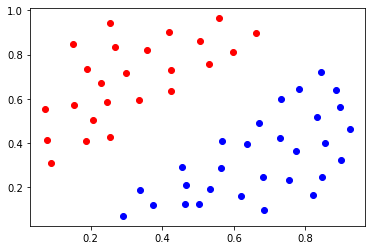

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
pointsClass1 = loadmat('KernelPointsEx4class1.mat')['PointsEx4class1']
pointsClass2 = loadmat('KernelPointsEx4class2.mat')['PointsEx4class2']


plt.scatter(pointsClass1[:,0], pointsClass1[:,1], c='r')
plt.scatter(pointsClass2[:,0], pointsClass2[:,1], c='b')
plt.show()

### Question II.1 (3pts)

Start by completing the function below which should return the value and gradient of the hinge loss at a point $\mathbf{x}^{(i)}$. What is the gradient of the hinge loss?

In [8]:
def HingeLoss(beta0, beta, x, t):
    '''Returns the value and gradient of the hinge 
    loss at the point x'''
    v0 = 1 - t * (np.dot(beta, x) + beta0)
    if (v0 < 0):
        value = 0
        gradient = np.zeros(beta.shape[0]+1)
    else:
        value = v0
        gradient = np.hstack([-t, -t*x])
    return value, gradient

### Question II.2 (7pts)

Once you have the function, implement a function HingeLossSVC that takes as innput a starting weight vector $\mathbf{\beta}$ and intercept $\beta_0$ as well as the set of training points and a value for the parameter $C$ and returns the maximum margin classifier.  

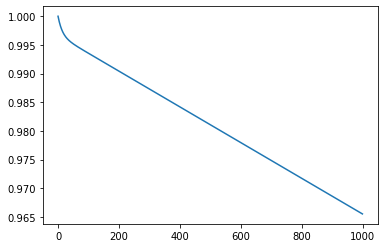

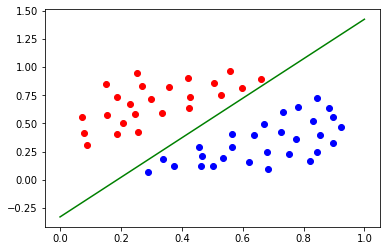

In [13]:
C = 0.1
lr = 0.035
def HingeLossSVC(beta0, beta, data, t, C, lr):
    '''Returns the maximal margin classifier for the 
    training dataset'''
    loss = []
    for i in range(1000):
        grad0 = 0
        grad = np.zeros(beta.shape[0])
        l0 = 0
        for j in range(len(data)):
            value, gradient = HingeLoss(beta0, beta, data[j], t[j])
            grad0 += C * gradient[0]
            grad +=  C * gradient[1:]
            l0 += value      
        beta0 -= lr * grad0 / len(data)
        beta -= lr * (grad / len(data) + 2*beta)
        loss.append(l0 / len(data))
    plt.plot(loss)
    plt.show()
    return beta0, beta
    
data = np.vstack([pointsClass1, pointsClass2])
t = np.hstack([np.ones(pointsClass1.shape[0]), -np.ones(pointsClass2.shape[0])])

beta0 = 0
beta = np.zeros(data.shape[1])
beta0, beta = HingeLossSVC(beta0, beta, data, t, C, lr)

xp = np.linspace(0, 1, 100)
y0 = (-beta[0] / beta[1])
yp = xp * y0 + beta0


plt.plot(xp, yp, c="g")
plt.scatter(pointsClass1[:,0], pointsClass1[:,1], c='r')
plt.scatter(pointsClass2[:,0], pointsClass2[:,1], c='b')
plt.show()

## Question III (5pts): Segmentation with K means

Upload a picture of yourself (possibly downsampled) and apply a Kmeans segmentation in the RGB space for a few distinct numbers of centroids (e.g. 5, 10, 20). 

original photo with img shape (44, 33, 3)


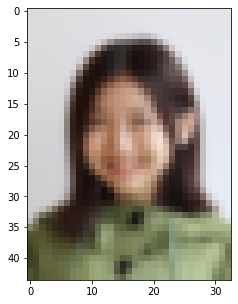


Current K is: 5


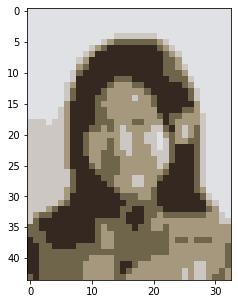


Current K is: 10


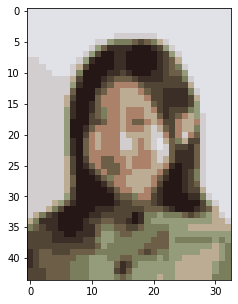


Current K is: 20


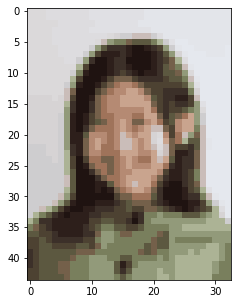

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy

def distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))


class KMeans():
    def __init__(self, K, max_iter, X=None):
        self.K = K
        self.max_iter = max_iter
        self.X = X
        self.clusters = [[] for _ in range(self.K)]
        self.centroids = []

    def _closest_centroid(self, sample):
        d = [distance(sample, center) for center in self.centroids]
        return np.argmin(d)

    def _create_clusters(self):
        self.clusters = [[] for _ in range(self.K)]
        for i in range(len(self.X)):
            centroid_i = self._closest_centroid(self.X[i])
            self.clusters[centroid_i].append(i)

    def _get_centroids(self):
        centroids = np.zeros((self.K, self.n_channels))
        for i in range(len(self.clusters)):
            cluster_mean = np.mean(self.X[self.clusters[i]], axis=0)
            centroids[i] = cluster_mean
        return centroids

    def _is_converged(self, old_centroids):
        d = [distance(old_centroids[i], self.centroids[i]) for i in range(self.K)]
        return sum(d) == 0

    def _get_cluster_labels(self):
        labels = np.zeros(self.n_samples)
        for i in range(len(self.clusters)):
            for j in self.clusters[i]:
                labels[j] = i
        return labels

    def process(self, X):
        self.X = X
        self.n_samples, self.n_channels = X.shape

        r_sample_i = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[i] for i in r_sample_i]

        for _ in range(self.max_iter):
            self._create_clusters()

            old_centroids = self.centroids
            self.centroids = self._get_centroids()

            if self._is_converged(old_centroids):
                break

        return self._get_cluster_labels()
    

Klist = [5, 10, 20]
max_iter = 1000

img = cv2.imread("me.png")
for i in range(5):
    img = cv2.pyrDown(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("original photo with img shape", img.shape)
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()
print()

for K in Klist:
    X = deepcopy(img)
    pixel = np.float32(X.reshape((-1, 3)))

    kmeans_solver = KMeans(K, max_iter)
    pred = kmeans_solver.process(pixel).astype(int)
    centroids = kmeans_solver.centroids.astype(int)  
    segmented = centroids[pred].reshape(X.shape)

    print("Current K is:", K)
    plt.figure(figsize=(5, 5))
    plt.imshow(segmented)
    plt.show()
    print()
